# <center> Capstone проект №1 <br>Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center> Подготовка и первичный анализ данных

Продолжим подготавливать данные для дальнейшего анализа и построения прогнозных моделей. Конкретно, раньше мы определили что сессия – это последовательность из 10 посещенных пользователем сайтов, теперь сделаем длину сессии параметром, и потом при обучении прогнозных моделей выберем лучшую длину сессии.
Также мы познакомимся с предобработанными данными и статистически проверим первые гипотезы, связанные с нашими наблюдениями. 

**План:**
 - Часть 1. Подготовка нескольких обучающих выборок для сравнения
 - Часть 2. Первичный анализ данных, проверка гипотез


## Часть 1. Подготовка нескольких обучающих выборок для сравнения

Пока мы брали последовательности из 10 сайтов, и это было наобум. Давайте сделаем число сайтов в сессии параметром, чтоб в дальнейшем сравнить модели классификации, обученные на разных выборках – с 5, 7, 10 и 15 сайтами в сессии. Более того, пока мы брали по 10 сайтов подряд, без пересечения. Теперь давайте применим идею скользящего окна – сессии будут перекрываться. 

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

Создадим несколько выборок для разных сочетаний параметров длины сессии и ширины окна. Все они представлены в табличке ниже:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Итого должно получиться 18 разреженных матриц – указанные в таблице 9 сочетаний параметров формирования сессий для выборок из 10 и 150 пользователей. При этом 2 выборки мы уже сделали в прошлой части, они соответствуют сочетанию параметров: session_length=10, window_size=10, которые помечены в таблице выше галочкой зеленого цвета (done).

функция *prepare_sparse_train_set_window*.

Аргументы:
- *path_to_csv_files* – путь к каталогу с csv-файлами
- *site_freq_path* – путь к pickle-файлу с частотным словарем, полученным в 1 части проекта
- *session_length* – длина сессии (параметр)
- *window_size* – ширина окна (параметр) 

Функция возвращает 2 объекта:
- разреженную матрицу *X_sparse* (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из *session_length* сайтов, а *max(site_id)* столбцов – количеству посещений *site_id* в сессии. 
- вектор *y* (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из *X_sparse*


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import glob
import os
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from  more_itertools import unique_everseen

In [3]:
def sparse_matrix(X):
    indptr = [0]
    indices = []
    data = []
    for row in X:
        for i in row:
            if i!=0:
                indices.append(i)
                data.append(1)
        indptr.append(len(indices))
    #csr_matrix((data, indices, indptr), dtype=int).toarray()
    return csr_matrix((data, indices, indptr), dtype=int)

In [7]:
# путь к данным
PATH_TO_DATA = 'C:\\Users\\wild-moray\\Desktop\\ML\\final\\capstone_user_identification'
PATH_TO_DICT= 'C:\\Users\\wild-moray\\Desktop\\ML\\final\\pkls'

In [5]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    users=[]
    for_sparse=[]
    os.chdir(path_to_csv_files) 
    with open(site_freq_path, 'rb') as f:
        vocab = pickle.load(f)
    allFiles = glob.glob('user*.csv')
    for file_ in allFiles:
        with open(file_) as f:
            temp=[]
            user_id=file_.split('.csv')[0].lstrip('user0')
            for row in f.readlines(): 
                word=row.split(',')[1].strip()
                if word!='site':
                    users.append(user_id)
                    temp.append(vocab[word][1])
        for i in range(0,len(temp),window_size):
            for_sparse.extend(temp[i:(i+session_length)])
            if len(for_sparse)%session_length!=0:
                for_sparse.extend(np.zeros(session_length-len(for_sparse)%session_length).astype('int'))
    users=np.array(users) 
    users_df=[]
    for user in list(unique_everseen(users)):
        t=users[users==user]
        if len(t)%window_size==0:
            users_df.extend([user]*int((len(t)/window_size)))
        else:
            users_df.extend([user]*int((len(t)/window_size)+1))
    X=sparse_matrix(np.array(for_sparse).reshape(int(len(for_sparse)/session_length),session_length))
    y=np.array(users_df).astype('int')
    return X,y

**Применим полученную функцию с параметрами *session_length=5* и *window_size=3* к игрушечному примеру. Убедимся, что все работает как надо.**

In [8]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'3users'), 
                                                       os.path.join(PATH_TO_DICT,'site_freq_3users.pkl'),
                                       session_length=5, window_size=3)

In [9]:
X_10_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'10users'), 
                                                       os.path.join(PATH_TO_DICT,'site_freq_10users.pkl'),
                                       session_length=15, window_size=5)

In [10]:
X_10_s5_w3.shape

(28118, 4914)

In [11]:
X_toy_s5_w3.todense().shape

(12, 12)

In [104]:
y_s5_w3

array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3])

In [9]:
y_s5_w3

array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3])

**Запустим созданную функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150), значениям параметра *session_length* (15, 10, 7 или 5) и значениям параметра *window_size* (10, 7 или 5). Сериализуем все 16 разреженных матриц (обучающие выборки) и векторов (метки целевого класса – ID пользователя) в файлы `X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl` и `y_{num_users}users_s{session_length}_w{window_size}.pkl`.**


In [12]:
%%time
import itertools

data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,str(num_users)+'users'), 
                                                       os.path.join(PATH_TO_DICT,'site_freq_'+str(num_users)+'users.pkl'),
                                                        session_length=session_length, window_size=window_size)
            data_lengths.append(X_sparse.shape[0])
            with open(os.path.join(PATH_TO_DICT,'X_sparse_'+str(num_users)+'users_s'+str(session_length)+
                                   '_w'+str(window_size)+'.pkl'), 'wb') as X_pkl:
                pickle.dump(X_sparse, X_pkl, protocol=2)
            with open(os.path.join(PATH_TO_DICT,
                                   'y_'+str(num_users)+'users_s'+str(session_length)+
                                   '_w'+str(window_size)+'.pkl'), 'wb') as y_pkl:
                pickle.dump(y, y_pkl, protocol=2)

Wall time: 1min 15s


**<font color='red'> Вопрос 1. </font>Сколько всего уникальных значений в списке `data_lengths`?**

In [13]:
data_lengths

[14061,
 20087,
 20087,
 20087,
 28118,
 28118,
 28118,
 28118,
 137019,
 195712,
 195712,
 195712,
 273957,
 273957,
 273957,
 273957]

## Часть 2. Первичный анализ данных, проверка гипотез

**Считаем в DataFrame подготовленный на 1 неделе файл `train_data_10users.csv`. Далее будем работать с ним.**

In [16]:
PATH_TO_DATA2='C:\\Users\\wild-moray\\Desktop\\ML\\final'

In [17]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA2, 'train_data_10users.csv'), 
                       index_col='session_id')

In [18]:
train_df.head()

,site0,site1,site2,site3,site4,site5,site6,site7,site8,site9,user_id
session_id,,,,,,,,,,,
0,192,574,133,3,133,133,3,133,203,133,31
1,415,193,674,254,133,31,393,3305,217,55,31
2,55,3,55,55,5,293,415,333,897,55,31
3,473,3306,473,55,55,55,55,937,199,123,31
4,342,55,5,3307,258,211,3308,2086,675,2086,31


In [11]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,193,574,133,3,133,133,3,133,203,133,31
1,415,192,675,254,133,31,393,3634,217,55,31
2,55,3,55,55,5,293,415,333,900,55,31
3,473,3395,473,55,55,55,55,944,199,123,31
4,342,55,5,3458,258,211,3369,2096,674,2096,31


In [132]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
site0      14061 non-null int64
site1      14061 non-null int64
site2      14061 non-null int64
site3      14061 non-null int64
site4      14061 non-null int64
site5      14061 non-null int64
site6      14061 non-null int64
site7      14061 non-null int64
site8      14061 non-null int64
site9      14061 non-null int64
user_id    14061 non-null int64
dtypes: int64(11)
memory usage: 1.3 MB


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
site1      14061 non-null int64
site2      14061 non-null int64
site3      14061 non-null int64
site4      14061 non-null int64
site5      14061 non-null int64
site6      14061 non-null int64
site7      14061 non-null int64
site8      14061 non-null int64
site9      14061 non-null int64
site10     14061 non-null int64
user_id    14061 non-null int64
dtypes: int64(11)
memory usage: 1.3 MB


**Распределение целевого класса:**

In [19]:
train_df['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [20]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [21]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

Text(0.5,1,'Распределение числа уникальных сайтов')

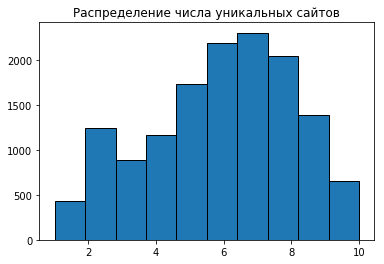

In [24]:
pd.Series(num_unique_sites).hist(edgecolor = 'black',grid=False)
plt.title('Распределение числа уникальных сайтов')

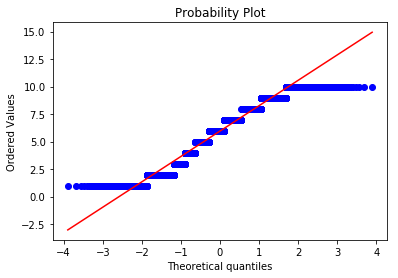

In [25]:
_ = stats.probplot(num_unique_sites, dist="norm", plot=plt)

**Проверьте с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально**

**<font color='red'> Вопрос 2. </font>Распределено ли нормально число уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов (согласно критерию Шапиро-Уилка)?**

In [139]:
rasp=pd.Series(num_unique_sites).value_counts()
rasp.values

array([2308, 2197, 2046, 1735, 1394, 1246, 1163,  894,  651,  427],
      dtype=int64)

In [140]:
from scipy import stats
stats.shapiro(rasp.values)

(0.952720046043396, 0.7007318139076233)

**Проверьте гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Давайте проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95% (обратите внимание, что альтернатива тому, что доля равна 95% –  одностороняя). Ответом на 3 вопрос в тесте будет полученное p-value.**

**<font color='red'> Вопрос 3. </font>Каково p-value при проверке описанной гипотезы?**

In [141]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [153]:
len(has_two_similar[has_two_similar==1])

13410

In [159]:
pi_val = stats.binom_test(sum(has_two_similar),len(has_two_similar),0.95,alternative='greater')
pi_val

0.02207653769072678

**<font color='red'> Вопрос 4. </font>Каков 95% доверительный интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт (из п. 3)?**

In [160]:
from statsmodels.stats.proportion import proportion_confint
wilson_interval = proportion_confint(sum(has_two_similar), len(has_two_similar), method = 'wilson')

In [161]:
print('{} {}'.format(round(wilson_interval[0], 3),
                                   round(wilson_interval[1], 3)))

0.95 0.957


**Постройте распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.**

In [26]:
freq=pd.Series(num_unique_sites).value_counts()
freq[freq>1000]

7    2308
6    2197
8    2046
5    1735
9    1394
2    1246
4    1163
dtype: int64

In [27]:
num_unique_sites=np.array(num_unique_sites)

In [180]:
site_freqs.index

Int64Index([7, 6, 8, 5, 9, 2, 4], dtype='int64')

In [39]:
freqs=np.array(freqs)
freqs=freqs[freqs>=1000]

Text(0.5,1,'Распределение частоты посещения сайтов(>=1000)')

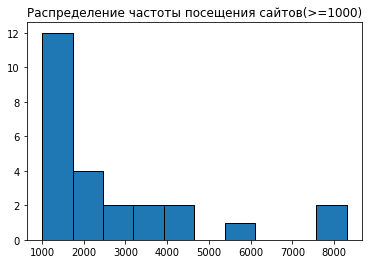

In [43]:
plt.hist(freqs,edgecolor = 'black')
plt.title('Распределение частоты посещения сайтов(>=1000)')

**Постройте 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap. Используйте столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям. Берите подвыборки из посчитанного списка частот посещений сайтов – не надо заново считать эти частоты. Учтите, что частоту появления нуля (сайт с индексом 0 появлялся там, где сессии были короче 10 сайтов) включать не надо. Округлите границы интервала до 3 знаков после запятой и запишите через пробел в файл *answer2_5.txt*. Это будет ответом на 5 вопрос теста.**

**<font color='red'> Вопрос 5. </font>Каков 95% доверительный интервал для средней частоты появления сайта в выборке?**

In [33]:
with open(os.path.join(PATH_TO_DICT,'site_freq_10users.pkl'), 'rb') as f:
    vocab = pickle.load(f)

In [34]:
n=len(vocab)

In [35]:
freqs=[]
for key in vocab.keys():
    freqs.append(vocab[key][0])

In [1]:
freqs=list(unique_everseen(freqs))

NameError: name 'unique_everseen' is not defined

In [162]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [163]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [226]:
samples=get_bootstrap_samples(np.array(freqs),len(freqs))

In [227]:
means=[]
for sample in samples:
    means.append(sample.mean())

In [232]:
interval=stat_intervals(means,0.05)
interval

array([22.51524527, 35.76303684])

In [233]:
print('{} {}'.format(round(interval[0], 3),
                                   round(interval[1], 3)))

22.515 35.763
